In [156]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as mt
from math import e
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from time import time
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import stats
import statsmodels.api as sm


# Input Fog Data 

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

# AO  Input


In [129]:
colspecs = [(0, 4), (5,7),(8,10),(11,None)]
#        result = read_fwf(StringIO(data), colspecs=colspecs, header=None)
df = pd.read_fwf("/home/cccr/diptih/dipti/Data/AO_EU/norm.daily.ao.index.ascii", colspecs=colspecs, header=None)
df[0] = df[0] .astype(str)+'-'+ df[1].astype(str)+'-'+ df[2].astype(str)
df2=df.drop([1,2],axis=1)
df2

,0,3
0,1950-1-1,-2.511
1,1950-1-2,-1.505
2,1950-1-3,-1.173
3,1950-1-4,-1.251
4,1950-1-5,-0.126
...,...,...
25959,2021-1-27,-3.202
25960,2021-1-28,-2.593
25961,2021-1-29,-2.726
25962,2021-1-30,-2.825


In [130]:
t1=pd.to_datetime(df2[0])
t2=t1.values.flatten()

In [131]:
ao_ds = xr.Dataset({'ao': (('time'), df[3])}, coords={'time': t2})

In [132]:
aoTS=ao_ds.ao.shift(time=1)


In [133]:
ao=aoTS[((aoTS.time.dt.month>11) | (aoTS.time.dt.month<2)) & (aoTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

In [134]:
ao.values=ao.values.astype(np.float)

# EU Input 

In [139]:
EUData = xr.open_dataset('../../../Data/AO_EU/EU.nc')
EUData.EUVal

<xarray.DataArray 'EUVal' (time: 2542)>
array([-0.36078 ,  0.140078,  0.621949, ..., -0.516587, -0.874138, -0.51686 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    average_op_ncl:  dim_avg_n over dimension(s): latitude,longitude
    units:           m**2 s**-2
    long_name:       Geopotential
    standard_name:   geopotential

In [140]:
euTS=EUData.EUVal.shift(time=1)

In [141]:
eu=euTS[((euTS.time.dt.month>11) | (euTS.time.dt.month<2)) & (euTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

# ERA5 Input



In [5]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

In [158]:
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [6]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tuv850D = tuv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
z850D = z850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [159]:
zD=z500Data.sel(latitude=slice(32,24),longitude=slice(74,86))


In [7]:
# Calculate wind speed and relative humidity
ws = ((v10D.v10.values**2)+(u10D.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh = (e**((17.625*(d2mD.d2m.values-273.15))/(243.04+(d2mD.d2m.values-273.15)))/e**((17.625*(t2mD.t2m.values-273.15))/(243.04+(t2mD.t2m.values-273.15))))
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
#Calculate inv
inv=t2mD.t2m.values-tuv850D.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [8]:
#u shear calculation
ushear=(tuv850D.u.values-u10D.u10.values)/(z850D.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'


In [9]:
# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values
# Chk mask
#t2mD.t2m.values=t2mD.t2m.values*mask
#t2mD.t2m[0,:,:].plot(cmap='jet')

In [160]:
# Apply Mask 
t2mD.t2m.values=t2mD.t2m.values*mask
ws_ds.ws.values=ws_ds.ws.values*mask
rh_ds.rh.values=rh_ds.rh.values*mask
w700D.w.values=w700D.w.values*mask
inv_ds.inv.values=inv_ds.inv.values*mask
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
zD.z.values=zD.z.values*mask

In [162]:
# Feild mean
t2mTS1=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m
wsTS1=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
wTS1=w700D.mean(dim=['latitude','longitude'], skipna=True).w
invTS1=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
ushearTS1=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
zTS1=zD.mean(dim=['latitude','longitude'], skipna=True).z

In [163]:
# shift one day so we can take values of previous day
t2mTS=t2mTS1.shift(time=1)
wsTS=wsTS1.shift(time=1)
rhTS=rhTS1.shift(time=1)
wTS=wTS1.shift(time=1)
invTS=invTS1.shift(time=1)
ushearTS=ushearTS1.shift(time=1)
zTS=zTS1.shift(time=1)

In [164]:
# Select required time 
t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
z=zTS[((zTS.time.dt.month>11) | (zTS.time.dt.month<2)) & (zTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

In [165]:
# input X
X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0,ao.values,eu.values,z.values]).T[:]
#X       = pd.DataFrame([ws.values,rh.values,inv.values,w.values]).T[:]
X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5,6,7,8
1980-01-01 09:00:00,289.120636,1.737170,0.681204,5.449228,-0.103194,0.353420,-2.380,0.326036,55956.152344
1980-01-02 09:00:00,288.971771,2.071385,0.743338,5.749483,-0.125205,0.273085,-2.546,0.821619,55678.570312
1980-01-03 09:00:00,288.303253,1.375861,0.758891,6.781636,-0.049128,0.160400,-2.085,0.484874,55675.070312
1980-01-04 09:00:00,287.083527,1.883535,0.746639,6.586329,0.070247,0.053234,-1.351,0.013497,55791.683594
1980-01-05 09:00:00,286.249054,1.991354,0.709822,5.626440,0.038802,0.038249,-1.361,0.433607,56015.648438
...,...,...,...,...,...,...,...,...,...
2014-12-27 09:00:00,286.107513,2.259315,0.695095,2.767421,0.122140,0.157532,-0.537,-0.300802,56791.929688
2014-12-28 09:00:00,285.829620,1.387228,0.669559,2.802088,0.080767,0.101353,-1.069,-0.729933,56794.851562
2014-12-29 09:00:00,285.367218,1.404445,0.691786,1.201003,0.032552,-0.067379,-1.280,-0.477308,56889.113281
2014-12-30 09:00:00,285.100342,1.548697,0.727608,0.743486,-0.013434,-0.084967,-0.257,0.531900,56507.863281


In [168]:
norm = StandardScaler().fit(X)
    # transform training data
X = norm.transform(X)
X

array([[ 0.08478527,  0.11248646,  0.6274767 , ..., -1.19572407,
         0.49410163, -1.28531843],
       [ 0.00633467,  0.99728945,  1.41436304, ..., -1.28213833,
         1.23646309, -1.88486484],
       [-0.34596934, -0.84404145,  1.61134034, ..., -1.04215657,
         0.73203347, -1.89242445],
       ...,
       [-1.89323784, -0.76836812,  0.76148799, ..., -0.6230995 ,
        -0.70927187,  0.72977375],
       [-2.03387961, -0.38647531,  1.2151491 , ..., -0.09055865,
         0.80247698, -0.09368398],
       [-2.05983682, -0.24962202,  1.67381266, ...,  0.64188024,
         0.83218427, -0.91594364]])

# Gradient Boosting Parameter Tuning

In [169]:
# build a classifier
gbReg = GradientBoostingRegressor(random_state=0)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'n_estimators':[300,500,1000],
              'min_samples_leaf': [5,10,15],
              'max_depth': [2,3,4],
              'learning_rate': [0.1,0.3,0.05,0.01]}

# run grid search
grid_search = GridSearchCV(gbReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

KeyboardInterrupt: 

Accuracy of base Gradient Boosting model is , 0.7425631286294789


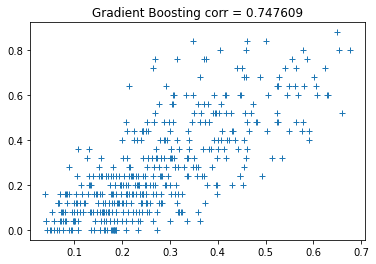

In [170]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = GradientBoostingRegressor(random_state=0,learning_rate= 0.01,max_depth= 3, min_samples_leaf= 15, n_estimators=500)
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base Gradient Boosting model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title('Gradient Boosting corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

# SVR Parameter Tuning 

In [150]:
svReg = SVR()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'kernel':[ 'rbf','poly' ,'sigmoid'  ],
              'gamma': ['scale', 'auto'],
              'C': [1,2,3,4,5,6],
              }

# run grid search
grid_search = GridSearchCV(svReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 117.02 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.374)
Parameters: {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: -0.012 (std: 0.396)
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: -0.036 (std: 0.365)
Parameters: {'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}



Accuracy of base SVR model is , 0.7507329751649384


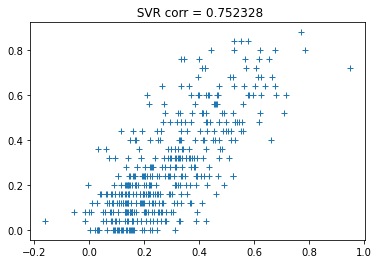

In [171]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 3, gamma='auto', kernel= 'rbf')
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

# Linear Regression

Accuracy of base Linear Regression model is , 0.7160307255977219


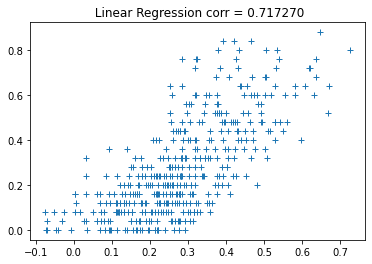

In [172]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regLin=LinearRegression().fit(X_train, y_train)
acc_svr       = round(regLin.score(X_test, y_test) * 100, 2)
print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)
yy_test = regLin.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' Linear Regression corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

ValueError: unrecognized data structures: <class 'xarray.core.dataarray.DataArray'> / <class 'numpy.ndarray'>

# Extreme Gradient Boosting

Accuracy of XGB model is , 0.7505997601918082


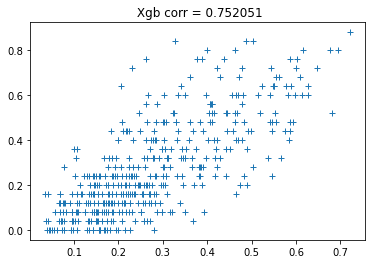

In [175]:
# define the model
model = XGBRegressor(n_estimators=100,learning_rate=0.05,max_depth=5,objective ='reg:squarederror' )
model.fit(X_train, y_train.values)
acc_svr       = round(model.score(X_test, y_test) * 100, 2)
print("Accuracy of XGB model is ,",(acc_svr/100)**0.5)
yy_test = model.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' Xgb corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')